In [2]:
import tensorflow as tf
from tensorflow.keras import utils
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from random import randint
from PIL import Image
from sklearn.model_selection import train_test_split
import cv2



In [3]:
def color2index(color):
  index=0
  if (color[0] + color[1] + color[2]) > 40 : index = 1 #выводы
  return index

In [4]:
def index2color(index2):
  index = np.argmax(index2)
  color = []
  if index == 0:
    color = [0, 0, 0] #всё остальное
  elif index == 1:
    color = [40, 255, 255] #выводы
  return color

In [5]:
# Функция перевода индекса пикслея в to_categorical
def rgbToohe(y, num_classes): 
  y2 = y.copy() # Создаем копию входного массива
  y = y.reshape(y.shape[0] * y.shape[1], 3) # Решейпим в двумерный массив
  yt = [] # Создаем пустой лист
  for i in range(len(y)): # Проходим по всем трем канала изображения
    yt.append(utils.to_categorical(color2index(y[i]), num_classes=num_classes)) # Переводим пиксели в индексы и преобразуем в OHE
  yt = np.array(yt) # Преобразуем в numpy
  yt = yt.reshape(y2.shape[0], y2.shape[1], num_classes) # Решейпим к исходныму размеру
  return yt # Возвращаем сформированный массив

In [6]:
# Функция формирования yTrain
def yt_prep(data, num_classes):
  yTrain = [] # Создаем пустой список под карты сегметации
  for seg in data: # Пробегаем по всем файлам набора с сегминтированными изображениями
    y = rgbToohe(seg, num_classes) # Получаем OHE-представление сформированного массива
    yTrain.append(y) # Добавляем очередной элемент в yTrain
    if len(yTrain) % 100 == 0: # Каждые 100 шагов
      print(len(yTrain)) # Выводим количество обработанных изображений
  return np.array(yTrain) # Возвращаем сформированный yTrain

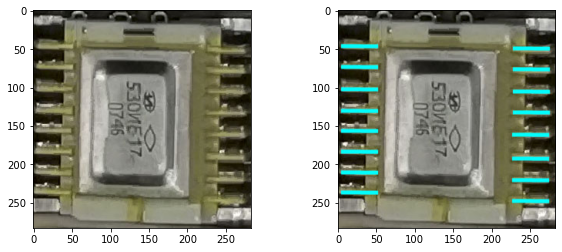

In [7]:
#путь к папке с данными
directory = './data/train/'
# Для тестовой выборки
# directory = './data/val/' 

#размер изображения 283х283
img = Image.open(directory+'/Без закрашивания/1.jpg')
mask = Image.open(directory+'/С закрашиванием/1.jpg')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
axes[0].imshow(img)
axes[1].imshow(mask)
plt.show()


In [8]:
%%time

img_micro = []
mask_micro = []

for i in range(0, 375): # фото №376 отсутствует
    img = np.array(Image.open(directory + '/Без закрашивания/'+str(i+1)+'.jpg'))
    mask = np.array(Image.open(directory+ '/С закрашиванием/' + str(i+1)+'.jpg'))
    img = cv2.resize(img, (256, 256))
    mask = cv2.resize(mask, (256, 256))
    img_micro.append(img)
    mask_micro.append(mask)
for i in range(377,803):
    img = np.array(Image.open(directory + '/Без закрашивания/'+str(i+1)+'.jpg'))
    mask = np.array(Image.open(directory+ '/С закрашиванием/' + str(i+1)+'.jpg'))
    img = cv2.resize(img, (256, 256))
    mask = cv2.resize(mask, (256, 256))
    img_micro.append(img)
    mask_micro.append(mask)
    
# Для тестовой выборки

# for i in range(803, 1000): # фото №376 отсутствует
#     img = np.array(Image.open(directory + '/Без закрашивания/'+str(i+1)+'.jpg'))
#     mask = np.array(Image.open(directory+ '/С закрашиванием/' + str(i+1)+'.jpg'))
#     img = cv2.resize(img, (256, 256))
#     mask = cv2.resize(mask, (256, 256))
#     img_micro.append(img)
#     mask_micro.append(mask)

Wall time: 7.69 s


In [9]:
images_micro = np.array(img_micro)
masks_micro = np.array(mask_micro)

In [10]:
segments = []
for i in range(masks_micro.shape[0]):
    hsv_mask = cv2.cvtColor(masks_micro[i], cv2.COLOR_RGB2HSV)
    light_yellow = (0, 240, 240)
    dark_yellow = (255, 255, 255)
    segment = cv2.inRange(hsv_mask, light_yellow, dark_yellow)
    result = cv2.bitwise_and(masks_micro[i], masks_micro[i], mask=segment)
    segments.append(result)

(801, 256, 256, 3)


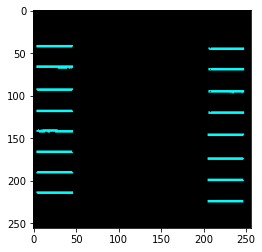

In [11]:
segment_micro = np.array(segments)
print(segment_micro.shape)
plt.imshow(segment_micro[0])

In [12]:
xTrain = [] # Создаем пустой список под обучающую выборку
for img in images_micro: 
#     x = image.img_to_array(img) # Переводим изображение в numpy-массив размерностью: высота - ширина - количество каналов
    xTrain.append(img) # Добавляем очередной элемент в xTrain
xTrain = np.array(xTrain) # Переводим в numpy
print(xTrain.shape) # Размерность обучающей выборки

(801, 256, 256, 3)


In [13]:
%%time

yTrain = yt_prep(segment_micro, 2)

C:\Users\pshen\AppData\Local\Temp/ipykernel_6008/1228413092.py:3: RuntimeWarning: overflow encountered in ubyte_scalars
  if (color[0] + color[1] + color[2]) > 40 : index = 1 #выводы


100
200
300
400
500
600
700
800
Wall time: 10min 36s


In [ ]:
#Сохраняем результаты для дальнейшего использования

# np.save('x_train.npy', xTrain, ) 
# np.save('y_train', yTrain, )
# np.save('x_test', list_val_img_x, )
# np.save('y_test', list_val_img_y, ) 
os.chdir(r'C:\Users\pshen\Desktop\Работа\Фотографии для нейросети')

x_train = np.load('./Semantic_segment/x_train.npy')
y_train = np.load('./Semantic_segment/y_train.npy')
x_test = np.load('./Semantic_segment/x_val.npy')
y_test = np.load('./Semantic_segment/y_val.npy')